In [10]:
# Import libraries
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
#nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
# Initialization
lemmatizer = WordNetLemmatizer()
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.015)
tfidf_transformer = TfidfTransformer()
nb_clf = MultinomialNB()

In [12]:
# Read in hand labeled data
filepath = "finalized_8K_accounts.csv"
df = pd.read_csv(filepath)

hand_label = "hand.label"
government = "gov"
academia = "acad"

df = pd.read_csv(filepath)

df = df[((df[hand_label]=='media') | (df[hand_label]== academia) | (df[hand_label]==government) | (df[hand_label]=='other' ))]


df = df[['username','description',hand_label]] # keep only relevant columns


print(df.head())
print()
print('Number of labels per category:')
print(df[hand_label].value_counts())
print()

       username                                        description hand.label
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other
1         enckj  Former EPA Regional Administrator, President o...       acad
2  nuclearkelly  Scientist at ORNL, DOE Early Career Awardee, F...       acad
3       stukhan  Dad. Director of the Australian Graduate Schoo...       acad
4       PatMag7  Podcasting about Feminist Participatory Action...       acad

Number of labels per category:
other    7232
media     397
acad      187
gov        36
Name: hand.label, dtype: int64



In [13]:
# Preprocessing step - lemmatization on description column
words_not_changed = ['media']
def preprocessing(row):
    row = str(row).lower()                                                                               # lowercase (so that upper and lowercase words are treated the same)
    row = word_tokenize(row)                                                                        # tokenize  (to perform lemmitization)
    row = [lemmatizer.lemmatize(word) if word not in words_not_changed else word for word in row]   # lemmatize
    return str(row)                                                                                 # convert back to string
df['description_lemmatized'] = df['description'].apply(preprocessing)                               # apply preprocessing function to description column
print(df.head())
print()

       username                                        description hand.label  \
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other   
1         enckj  Former EPA Regional Administrator, President o...       acad   
2  nuclearkelly  Scientist at ORNL, DOE Early Career Awardee, F...       acad   
3       stukhan  Dad. Director of the Australian Graduate Schoo...       acad   
4       PatMag7  Podcasting about Feminist Participatory Action...       acad   

                              description_lemmatized  
0  ['army', 'civil', 'service', '(', 'retired', '...  
1  ['former', 'epa', 'regional', 'administrator',...  
2  ['scientist', 'at', 'ornl', ',', 'doe', 'early...  
3  ['dad', '.', 'director', 'of', 'the', 'austral...  
4  ['podcasting', 'about', 'feminist', 'participa...  



In [14]:
# Split data into train and test sets (stratified so that each class is represented proportionately in train and test sets)
X = df['description_lemmatized']
y = df['hand.label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify to keep a representative proportion of each class

In [15]:
print(X_train.shape)

(6281,)


In [16]:
print(y_train)

230     media
2191    other
7314    other
6413    other
2665    other
        ...  
5271    other
2705    other
4142    other
1981    other
7243    other
Name: hand.label, Length: 6281, dtype: object


In [17]:
print(y_train.value_counts())

other    5785
media     317
acad      150
gov        29
Name: hand.label, dtype: int64


In [18]:
print(y_test.value_counts())

other    1447
media      80
acad       37
gov         7
Name: hand.label, dtype: int64


In [19]:
# Pipeline Creation for Naive Bayes word frequencies and tfidf weighting
nb_count_pipeline = Pipeline([('vectorizer', count_vectorizer),
                              ('classifier', nb_clf)])

param_count_grid = [
    {'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20],
     'classifier__alpha': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
     'classifier__fit_prior': [True, False]}
]

grid_search_count = GridSearchCV(nb_count_pipeline, param_count_grid, cv=5, scoring='accuracy', verbose=1)

nb_tfidf_pipeline = Pipeline([('vectorizer', count_vectorizer),
                              ('transformer', tfidf_transformer),
                              ('classifier', nb_clf)])

param_tfidf_grid = [
    {'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20],
        'transformer__use_idf': [True, False],
        'classifier__alpha': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__fit_prior': [True, False]}
]

grid_search_tfidf = GridSearchCV(nb_tfidf_pipeline, param_tfidf_grid, cv=5, scoring='accuracy', verbose=1)

In [20]:
# Best hyperparameters for Naive Bayes word frequencies and tfidf weighting
grid_search_count.fit(X_train, y_train)
grid_search_tfidf.fit(X_train, y_train)

print('NB word frequencies - cross validation accuracy:')
print(grid_search_count.best_score_)
print()

print('NB word frequencies - best parameters:')
print(grid_search_count.best_params_)
print()

print('NB tfidf - cross validation accuracy:')
print(grid_search_tfidf.best_score_)
print()

print('NB tfidf - best parameters:')
print(grid_search_tfidf.best_params_)
print()

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/

Fitting 5 folds for each of 140 candidates, totalling 700 fits
NB word frequencies - cross validation accuracy:
0.9259674485302686

NB word frequencies - best parameters:
{'classifier__alpha': 5.0, 'classifier__fit_prior': True, 'vectorizer__min_df': 0.01}

NB tfidf - cross validation accuracy:
0.9294702532062488

NB tfidf - best parameters:
{'classifier__alpha': 1e-10, 'classifier__fit_prior': True, 'transformer__use_idf': False, 'vectorizer__min_df': 0.01}



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
200 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib

In [21]:
nb_count_pipeline.set_params(**grid_search_count.best_params_)
nb_tfidf_pipeline.set_params(**grid_search_tfidf.best_params_)
nb_count_pipeline.fit(X_train, y_train)
nb_tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.01, stop_words='english')),
                ('transformer', TfidfTransformer(use_idf=False)),
                ('classifier', MultinomialNB(alpha=1e-10))])

Confusion Matrix for NB word frequencies:


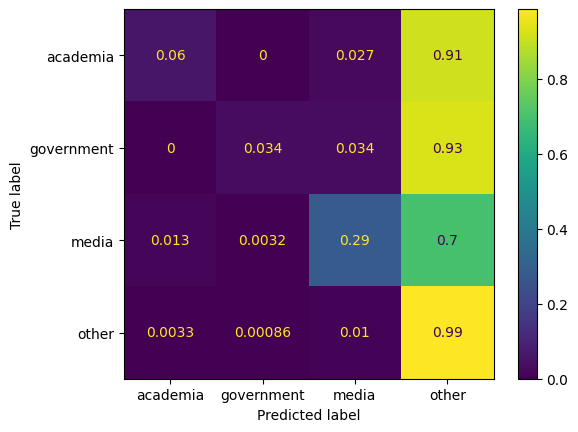

Confusion Matrix for NB tfidf:


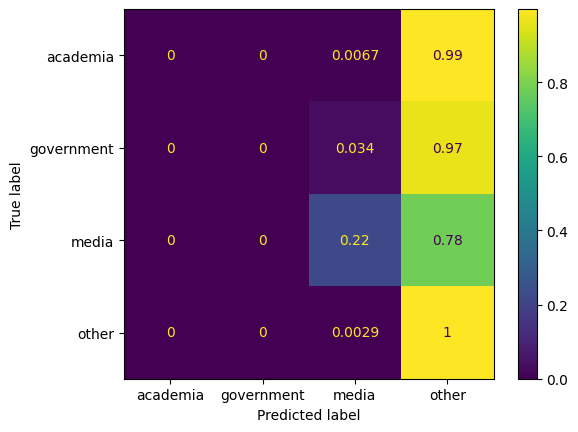

In [22]:
# Cross Fold Confusion Matrix for Train set
y_pred_count = cross_val_predict(nb_count_pipeline, X_train, y_train, cv=5)
y_pred_tfidf = cross_val_predict(nb_tfidf_pipeline, X_train, y_train, cv=5)

cm_count = confusion_matrix(y_train, y_pred_count, normalize='true')
cm_tfidf = confusion_matrix(y_train, y_pred_tfidf, normalize='true')

disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count, display_labels=['academia', 'government', 'media', 'other'])
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['academia', 'government', 'media', 'other'])
print('Confusion Matrix for NB word frequencies:')
disp_count.plot()
plt.show()
print('Confusion Matrix for NB tfidf:')
disp_tfidf.plot()
plt.show()

In [23]:
print("Word-Frequencies Classification Report:")
print(metrics.classification_report(y_train, y_pred_count))
print()
print("TF-IDF Classification Report:")
print(metrics.classification_report(y_train, y_pred_tfidf))

Word-Frequencies Classification Report:
              precision    recall  f1-score   support

        acad       0.28      0.06      0.10       150
         gov       0.14      0.03      0.06        29
       media       0.58      0.29      0.38       317
       other       0.94      0.99      0.96      5785

    accuracy                           0.92      6281
   macro avg       0.49      0.34      0.37      6281
weighted avg       0.90      0.92      0.91      6281


TF-IDF Classification Report:
              precision    recall  f1-score   support

        acad       0.00      0.00      0.00       150
         gov       0.00      0.00      0.00        29
       media       0.79      0.22      0.34       317
       other       0.93      1.00      0.96      5785

    accuracy                           0.93      6281
   macro avg       0.43      0.30      0.33      6281
weighted avg       0.90      0.93      0.90      6281



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [24]:
# Fit models with best hyperparamets and predict on test set
y_pred_count = nb_count_pipeline.predict(X_test)
y_pred_tfidf = nb_tfidf_pipeline.predict(X_test)

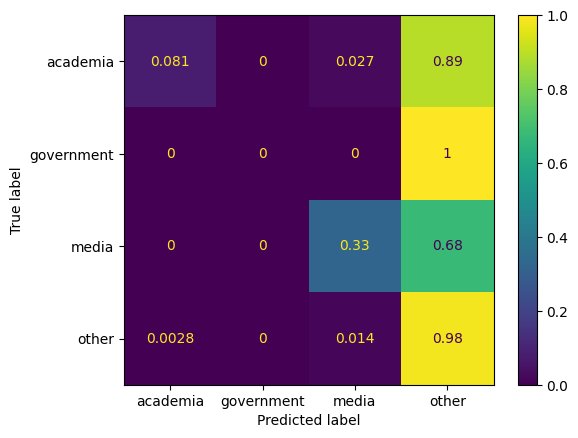

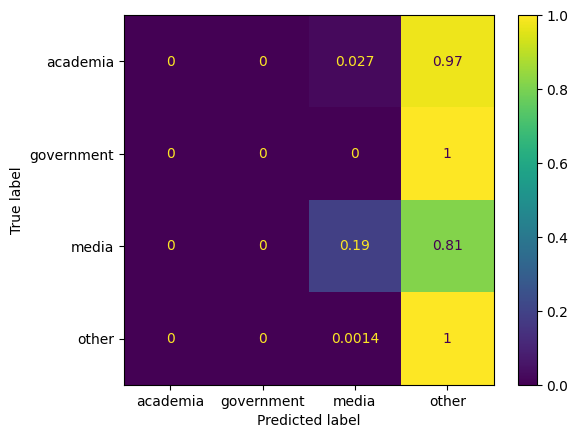

In [25]:
# Confusion Matrix
cm_count = confusion_matrix(y_test, y_pred_count, normalize='true')
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, normalize='true')

disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count, display_labels=['academia', 'government', 'media', 'other'])
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['academia', 'government', 'media', 'other'])

disp_count.plot()
plt.show()

disp_tfidf.plot()
plt.show()

In [26]:
# Print classification report
print("Word-Frequencies Classification Report:")
print(metrics.classification_report(y_test, y_pred_count))
print()

print("TF-IDF Classification Report:")
print(metrics.classification_report(y_test, y_pred_tfidf))
print()

Word-Frequencies Classification Report:
              precision    recall  f1-score   support

        acad       0.43      0.08      0.14        37
         gov       0.00      0.00      0.00         7
       media       0.55      0.33      0.41        80
       other       0.94      0.98      0.96      1447

    accuracy                           0.92      1571
   macro avg       0.48      0.35      0.38      1571
weighted avg       0.90      0.92      0.91      1571


TF-IDF Classification Report:
              precision    recall  f1-score   support

        acad       0.00      0.00      0.00        37
         gov       0.00      0.00      0.00         7
       media       0.83      0.19      0.31        80
       other       0.93      1.00      0.96      1447

    accuracy                           0.93      1571
   macro avg       0.44      0.30      0.32      1571
weighted avg       0.90      0.93      0.90      1571




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa